<a href="https://colab.research.google.com/github/poliduckie/ReinforcementLearning/blob/main/notebooks/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train duckietown with stable baseline

Environment setup 

In [ ]:
import os 
if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
  branch = "daffy" #@param ['master', 'daffy']
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if "/gym-duckietown" not in os.getcwd():
  os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.


Install stable baseline

In [ ]:
# Stable baseline requires tensorflow 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
!apt update && apt install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip3 install stable-baselines[mpi]
#This version with mpi is apparently broken, see:
#https://github.com/hill-a/stable-baselines/issues/464
!pip3 install stable-baselines --upgrade

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
map_name = "Duckietown-small_loop-v0" #@param ['Duckietown-straight_road-v0','Duckietown-4way-v0','Duckietown-udem1-v0','Duckietown-small_loop-v0','Duckietown-small_loop_cw-v0','Duckietown-zigzag_dists-v0','Duckietown-loop_obstacles-v0','Duckietown-loop_pedestrians-v0']

Wrapper to highlight lines

In [ ]:
import cv2
import gym
from gym.spaces import Box

cutted_img_height = 350 #@param {type: "slider", min: 0, max: 480, step:1}
resize_ratio = 0.35 #@param {type: "slider", min: 0.0, max: 1.0, step:0.01}

img_height = 480
top_crop = img_height - cutted_img_height

img_final_height = int(cutted_img_height * resize_ratio)
img_final_width = int(640 * resize_ratio)

def cropimg(img):
    """
    Crop top of image top_crop px, they are noise most of the time

    :param img: (RGB image as np array) Image to be cropped
    """
    return img[top_crop:,:]

def houghtransform(img):
    """
    Apply Hough Line transform, for theory see:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

    :param img: (RGB image as np array)
    """
    frame_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY, 3)
    edges = cv2.Canny(frame_BGR,50,150,apertureSize = 3)
    #minLineLength = 100
    #maxLineGap = 10
    #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    #for x1,y1,x2,y2 in lines[0]:
    #    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    imgRGB = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
    return imgRGB

def resizeimg(img, ratio):
    """
    Resize image
    :param img: (np array)
    :param ratio: (float) 0<ratio<1
    """
    return cv2.resize(img, (0,0), fx=ratio, fy=ratio) 
  
def takeyellow(img):
    """
    Extract yellow lines, for color ranges see:
    https://stackoverflow.com/questions/48109650/how-to-detect-two-different-colors-using-cv2-inrange-in-python-opencv

    :param img: (RGB image as np array)
    """
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    frame_threshold = cv2.inRange(frame_HSV, (20,100,100), (50, 255, 255))
    imgRGB = cv2.cvtColor(frame_threshold, cv2.COLOR_GRAY2RGB)
    return imgRGB

def takewhiteyellow(img):
    """
    Extract white and yellow lines

    :param img: (RGB image as np array)
    """
    #white
    sensitivity = 100
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    maskwhite = cv2.inRange(frame_HSV, lower_white, upper_white)
    img[maskwhite > 0] = (255, 0, 0)
    img[maskwhite == 0] = (0,0,0)
    #yellow
    maskyellow = cv2.inRange(frame_HSV, (15,70,70), (50, 255, 255))
    img[maskyellow > 0] = (0, 255, 0)
    return img

def white_balance(img):
    """
    Grayworld assumption:
    https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption/46391574

    :param img: (RGB image as np array)
    """
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

class ObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(ObsWrapper, self).__init__(env)
        self.observation_space = Box(0, 255, (img_final_height, img_final_width, 3), dtype=self.observation_space.dtype)
        self.accept_start_angle_deg = 4
        self.env = env

    def observation(self, obs):
        cropped = cropimg(obs)
        resized = resizeimg(cropped, resize_ratio)
        balanced = white_balance(resized)
        img = takewhiteyellow(balanced)
        return img

In [ ]:
class NormalizeWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(NormalizeWrapper, self).__init__(env)
        self.observation_space = Box(0, 1, self.observation_space.shape, dtype=self.observation_space.dtype)
        self.env = env

    def observation(self, obs):
        obs = obs/255
        return obs

Wrapper result example:

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /usr/local/lib/python3.7/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.7/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /usr/local/lib/python3.7/dist-packages
DEBUG:nodes:version 6.2.13 path /usr/local/lib/python3.7/dist-packages pyparsing 3.0.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.31 path /content/gym-duckietown/src



{'audio': ('directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True}


INFO:gym-duckietown:Information about the graphics card:
 pyglet_version: 1.5.0
    information: dict[4]
                 │ vendor: VMware, Inc.
                 │ renderer: llvmpipe (LLVM 10.0.0, 256 bits)
                 │ version: 3.1 Mesa 20.0.8
                 │ shading-language-version: 1.40
  nvidia_around: False
DEBUG:gym-duckietown:Falling back to non-multisampled frame buffer
DEBUG:gym-duckietown:Falling back to non-multisampled frame buffer
INFO:duckietown_world: data: /usr/local/lib/python3.7/dist-packages/duckietown_world/data
DEBUG:gym-duckietown:loading map file "/usr/local/lib/python3.7/dist-packages/duckietown_world/data/gd1/maps/small_loop.yaml"
INFO:gym-duckietown:done
DEBUG:gym-duckietown:loading mesh 'duckiebot' from file_path '/usr/local/lib/python3.7/dist-packages/duckietown_world/data/gd1/meshes/duckiebot/duckiebot.obj'
DEBUG:gym-duckietown:loading materials from /usr/local/lib/python3.7/dist-packages/duckietown_world/data/gd1/meshes/duckiebot/duckiebot.mtl
DE

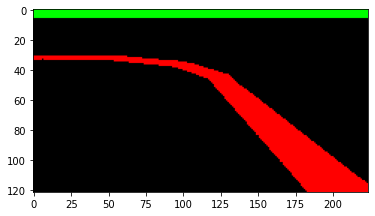

In [ ]:
import gym_duckietown

display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name)
env = ObsWrapper(env)
plt.imshow(env.reset())

In [ ]:
n = 10000
x_train = []
for i in range (n):
  x_train.append(env.reset())

INFO:gym-duckietown:Starting at [1.42025422 0.         0.44069523] 4.720976604722487
INFO:gym-duckietown:Starting at [0.10869467 0.         1.54832614] 2.1248408765298796
DEBUG:gym-duckietown:No tile found at [1.79664663 0.         0.84907835] (3, 1)
DEBUG:gym-duckietown:Invalid pose. Collision free: True On drivable area: False
DEBUG:gym-duckietown:safety_factor: 1.3
DEBUG:gym-duckietown:pos: [1.70769366 0.         0.88899851]
DEBUG:gym-duckietown:l_pos: [1.79664663 0.         0.84907835]
DEBUG:gym-duckietown:r_pos: [1.61874069 0.         0.92891867]
DEBUG:gym-duckietown:f_pos: [1.75559785 0.         0.99574207]
INFO:gym-duckietown:Starting at [1.58522443 0.         1.0983637 ] 4.1439305306994
DEBUG:gym-duckietown:[0.72411411 0.         0.60120614] corresponds to tile at (1, 1) which is not drivable: {'coords': (1, 1), 'kind': 'asphalt', 'angle': 1, 'drivable': False, 'texture': <gym_duckietown.graphics.Texture object at 0x7fef884c5550>, 'color': array([0.96750463, 1.12805994, 1.19442

In [ ]:
x_train = [i.astype('float32') / 255. for i in x_train]
len(x_train)

In [ ]:
x_test = x_train[8000:]
x_train = x_train[:8000]

x_train = [np.mean(i, axis=2) for i in x_train]
x_test = [np.mean(i, axis=2) for i in x_test]

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 122, 224, 1))
x_test = np.reshape(x_test, (len(x_test), 122, 224, 1))

In [ ]:
print(x_train.shape, x_test.shape)

In [ ]:
import keras
from keras import layers
import tensorflow as tf

input_img = keras.Input(shape=(122, 224, 1))
input_img_padding = layers.ZeroPadding2D((1,2))(input_img)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_padding)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded_cropping = layers.Cropping2D((1,2))(decoded)

autoencoder = keras.Model(input_img, decoded_cropping)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 122, 224, 1)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 124, 228, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 228, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 114, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 114, 8)        1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 57, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 57, 8)         584 

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

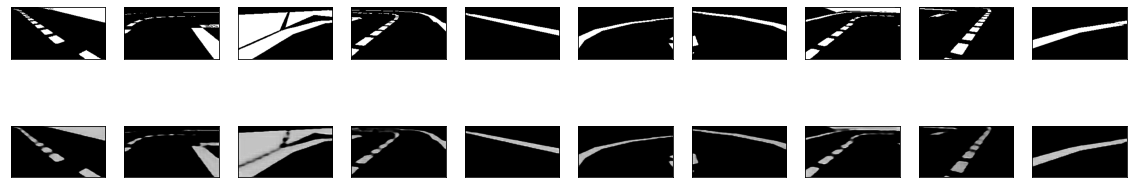

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(122, 224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(122, 224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()